# Paper 1 Results

In [ ]:
import os
import pandas as pd
import numpy as np
cwd = os.getcwd()
print(cwd)

In [3]:
# Define the directory containing the anonymized files
anonymized_dir = 'Anonymized'

# Define the date range for filtering
start_date = pd.to_datetime('2023-07-01')
end_date = pd.to_datetime('2023-09-30 23:59:59') 

# Initialize a list to store dataframes
dataframes = []

# Iterate over each file in the directory
for file_name in os.listdir(anonymized_dir):
    if file_name.startswith('miner_') and file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(anonymized_dir, file_name)
        
        # Extract the facility ID from the file name
        facility_id = int(file_name.split('_')[1])
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Convert the 'DateTime' column to datetime format
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        # Filter the dataframe for the specified date range
        filtered_df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]
        
        # Add the facility ID as a new column
        filtered_df['Facility ID'] = facility_id

        # Resetting index
        filtered_df.reset_index(drop=True, inplace=True)
        
        # Append the filtered dataframe to the list
        dataframes.append(filtered_df)

# Now, `dataframes` is a list of dataframes, each containing the filtered data with a 'Facility ID' column
dataframes[20]

DateTime         MWh       LME  Hour  WeekDay  Month  Day  \
0    2023-07-01 00:00:00  116.689122  0.626578     0        5      7    1   
1    2023-07-01 01:00:00  118.423854  0.707231     1        5      7    1   
2    2023-07-01 02:00:00  117.497875  0.664274     2        5      7    1   
3    2023-07-01 03:00:00  116.677942  0.679623     3        5      7    1   
4    2023-07-01 04:00:00  115.846418  0.567484     4        5      7    1   
...                  ...         ...       ...   ...      ...    ...  ...   
2198 2023-09-30 19:00:00  116.795650  0.891994    19        5      9   30   
2199 2023-09-30 20:00:00  116.638009  0.623603    20        5      9   30   
2200 2023-09-30 21:00:00  115.585745  0.591419    21        5      9   30   
2201 2023-09-30 22:00:00  114.923049  0.551961    22        5      9   30   
2202 2023-09-30 23:00:00  113.983673  0.566051    23        5      9   30   

          energy  daily_max_energy  DR_underclock_threshold  ...  \
0     120.104451        120.104451               108.094006  ...   
1     120.104451        120.104451               108.094006  ...   
2     120.104451        120.104451               108.094006  ...   
3     120.104451        120.104451               108.094006  ...   
4     120.104451        120.104451               108.094006  ...   
...          ...               ...                      ...  ...   
2198  116.795650        116.795650               105.116085  ...   
2199  116.638009        116.795650               105.116085  ...   
2200  115.585745        116.795650               105.116085  ...   
2201  114.923049        116.795650               105.116085  ...   
2202  113.983673        116.795650               105.116085  ...   

      energy_daily_avg_no_dr  energy_savings  DR_percent  curtailment_start  \
0                 120.104451        0.000000         0.0              False   
1                 120.104451        0.000000         0.0              False   
2                 120.104451        0.000000         0.0              False   
3                 120.104451        0.000000         0.0              False   
4                 120.104451        0.000000         0.0              False   
...                      ...             ...         ...                ...   
2198              112.569261       -4.226389         0.0              False   
2199              112.569261       -4.068749         0.0              False   
2200              112.569261       -3.016484         0.0              False   
2201              112.569261       -2.353789         0.0              False   
2202              112.569261       -1.414412         0.0              False   

      curtailment_end  DR_active  induced_emissions  avoided_emissions  \
0               False      False          75.254807                0.0   
1               False      False          84.941591                0.0   
2               False      False          79.782264                0.0   
3               False      False          81.625747                0.0   
4               False      False          68.157354                0.0   
...               ...        ...                ...                ...   
2198            False      False         104.181019                0.0   
2199            False      False          72.735813                0.0   
2200            False      False          68.359605                0.0   
2201            False      False          63.433041                0.0   
2202            False      False          64.520572                0.0   

      net_emissions  Facility ID  
0         75.254807           11  
1         84.941591           11  
2         79.782264           11  
3         81.625747           11  
4         68.157354           11  
...             ...          ...  
2198     104.181019           11  
2199      72.735813           11  
2200      68.359605           11  
2201      63.433041           11  
2202      64.520572           11  

[2203 rows x 21

In [4]:
import pandas as pd
import numpy as np

def calculate_targeting_efficiency_score(dataframes):
    """
    Calculates the Targeting Efficiency Score (TES) for each facility.
    TES = B_actual / B_best, where B_best is the theoretical maximum avoided 
    emissions if the actual curtailed MWh were perfectly aligned with the 
    highest-LME hours.

    Args:
        dataframes (list of pd.DataFrame): A list where each element is a 
                                           DataFrame for a single facility.
                                           Required columns: 'MWh', 'LME', 
                                           'energy_daily_avg_no_dr', 'DR_active'.

    Returns:
        pd.DataFrame: A DataFrame containing the 'Facility ID' and the 
                      calculated 'Targeting Efficiency Score (TES)' for each facility.
    """
    results = []

    for df in dataframes:
        if df.empty:
            continue

        facility_id = df['Facility ID'].iloc[0]
        
        # 1. Prepare Data for Marginal Calculation (delta E * LME)
        # Note: We use the Net Impact calculation's foundation, but focus only on the benefit.
        df_analysis = df.copy()
        df_analysis['Load_Reduction_MWh'] = df_analysis['energy_daily_avg_no_dr'] - df_analysis['MWh']
        df_analysis['Marginal_Impact'] = df_analysis['Load_Reduction_MWh'] * df_analysis['LME']
        
        # We only care about the positive reduction (where a saving occurred)
        df_analysis['Marginal_Impact'] = df_analysis['Marginal_Impact'].clip(lower=0) 
        
        # --- CALCULATE B_ACTUAL (Actual Carbon Benefit) ---
        
        # Filter for actual curtailment hours where the load was successfully reduced
        # This is where Load_Reduction_MWh > 0 and DR_active is True
        df_actual_curtailment = df_analysis[
            (df_analysis['DR_active'] == True) & 
            (df_analysis['Load_Reduction_MWh'] > 0)
        ]
        
        # B_actual = Sum of avoided emissions during actual curtailment events
        B_actual = df_actual_curtailment['Marginal_Impact'].sum()
        
        # Total MWh actually curtailed by the facility (sum of the curtailment depth)
        Total_Curtailed_MWh = df_actual_curtailment['Load_Reduction_MWh'].sum() 

        # If no curtailment occurred, TES is undefined or 0
        if Total_Curtailed_MWh <= 0:
            results.append({'Facility ID': facility_id, 'Targeting Efficiency Score (TES)': 0.0})
            continue

        # --- CALCULATE B_BEST (Theoretical Maximum Carbon Benefit) ---
        
        # 1. Sort all hours in the study period by LME, highest first.
        # This is the full opportunity space for the facility.
        df_sorted = df_analysis.sort_values(by='LME', ascending=False).reset_index(drop=True)
        
        # 2. Greedily fill the Theoretical Max Curtailment (B_best)
        B_best = 0
        mwh_remaining = Total_Curtailed_MWh
        
        # Iterate through the sorted hours (highest LME first)
        for index, row in df_sorted.iterrows():
            current_lme = row['LME']
            
            # The maximum curtailment we can assign to any single hour is the facility's baseline load
            # Here we assume the facility's maximum possible hourly curtailment is the average baseline
            # Note: Using the daily average here for maximum single-hour load reduction is a safe assumption.
            Max_Hourly_Curtailment = row['energy_daily_avg_no_dr'].iloc[0] if isinstance(row['energy_daily_avg_no_dr'], pd.Series) else row['energy_daily_avg_no_dr']

            # Determine how much MWh to assign to this hour
            mwh_assigned = min(mwh_remaining, Max_Hourly_Curtailment)
            
            # Add the benefit to B_best
            B_best += mwh_assigned * current_lme
            
            # Update remaining MWh
            mwh_remaining -= mwh_assigned
            
            # Stop if all MWh have been assigned
            if mwh_remaining <= 0:
                break
        
        # --- CALCULATE TES ---
        if B_best > 0:
            TES = B_actual / B_best
        else:
            TES = 0.0 # Should only happen if LME is always 0, which is unlikely

        results.append({
            'Facility ID': facility_id, 
            'Targeting Efficiency Score (TES)': TES
        })

    return pd.DataFrame(results)

# NOTE: The 'dataframes' list must be defined in the execution environment 
# before calling calculate_targeting_efficiency_score(dataframes).

# Execute the calculation
tes_results = calculate_targeting_efficiency_score(dataframes)

# Print the final results
print("--- Targeting Efficiency Score (TES) Results ---")
print("TES is a normalized score between 0 and 1.0.")
print(tes_results.to_markdown(index=False, floatfmt=".4f"))

--- Targeting Efficiency Score (TES) Results ---
TES is a normalized score between 0 and 1.0.
|   Facility ID |   Targeting Efficiency Score (TES) |
|--------------:|-----------------------------------:|
|       18.0000 |                             0.8846 |
|       12.0000 |                             0.6677 |
|       17.0000 |                             0.3734 |
|       14.0000 |                             0.7266 |
|        5.0000 |                             0.7299 |
|       21.0000 |                             0.7532 |
|        2.0000 |                             0.3852 |
|        3.0000 |                             0.3820 |
|        9.0000 |                             0.3117 |
|       20.0000 |                             0.6986 |
|        4.0000 |                             0.4231 |
|       15.0000 |                             0.6927 |
|        8.0000 |                             0.3031 |
|       19.0000 |                             0.2395 |
|        7.0000 |         

In [5]:
import pandas as pd
import numpy as np

# Collect results for all facilities here
all_daily_lf = []

for df in dataframes:
    # Skip empty frames
    if df is None or df.empty:
        continue

    # Ensure Facility ID exists and is scalar for this frame
    if 'Facility ID' not in df.columns or df['Facility ID'].empty:
        continue
    facility_id = df['Facility ID'].iloc[0]

    # Ensure needed columns exist
    required_cols = {'DateTime', 'energy', 'daily_max_energy'}
    missing = required_cols - set(df.columns)
    if missing:
        # Skip if columns needed are missing
        continue

    # Build a proper date column (date only, no time)
    # If DateTime is already datetime dtype this is fast; otherwise convert
    if not pd.api.types.is_datetime64_any_dtype(df['DateTime']):
        df = df.copy()
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

    df = df.dropna(subset=['DateTime'])  # drop rows where DateTime failed to parse
    if df.empty:
        continue

    df = df.copy()
    df['Date'] = df['DateTime'].dt.date  # pure date (Python date objects)

    # We only keep full 24-hour days as requested
    counts = df.groupby('Date', as_index=False)['energy'].size().rename(columns={'size':'n_hours'})
    full_days = counts.loc[counts['n_hours'] == 24, 'Date']

    if full_days.empty:
        continue

    # Filter to full days
    dff = df[df['Date'].isin(full_days)].copy()

    # Daily aggregations (vectorized)
    daily_agg = dff.groupby('Date', as_index=False).agg(
        total_energy=('energy', 'sum'),                # kWh per day
        peak_load=('daily_max_energy', 'max')          # kW (avg kW over the peak hour)
    )

    # Average daily load over 24h (per your requirement)
    daily_agg['avg_load'] = daily_agg['total_energy'] / 24.0

    # Load factor = avg_load / peak_load; guard against zero/NaN peak
    daily_agg['load_factor'] = np.where(
        (daily_agg['peak_load'] > 0) & np.isfinite(daily_agg['peak_load']),
        daily_agg['avg_load'] / daily_agg['peak_load'],
        np.nan
    )

    # Add Facility ID and convenience date parts
    daily_agg['Facility ID'] = facility_id
    # If you want Month/Day back as columns:
    daily_agg['Month'] = pd.to_datetime(daily_agg['Date']).dt.month
    daily_agg['Day']   = pd.to_datetime(daily_agg['Date']).dt.day
    daily_agg['WeekDay'] = pd.to_datetime(daily_agg['Date']).dt.weekday  # 0=Mon

    # Reorder columns (optional)
    daily_agg = daily_agg[
        ['Facility ID', 'Date', 'Month', 'Day', 'WeekDay',
         'total_energy', 'avg_load', 'peak_load', 'load_factor']
    ]

    all_daily_lf.append(daily_agg)

# Final combined dataframe across all facilities
load_factor_df = pd.concat(all_daily_lf, ignore_index=True) if all_daily_lf else pd.DataFrame(
    columns=['Facility ID','Date','Month','Day','WeekDay','total_energy','avg_load','peak_load','load_factor']
)

# Example: inspect
# load_factor_df.head()

load_factor_df

Facility ID        Date  Month  Day  WeekDay  total_energy    avg_load  \
0              18  2023-07-01      7    1        5    112.911072    4.704628   
1              18  2023-07-02      7    2        6    110.635963    4.609832   
2              18  2023-07-03      7    3        0     79.451045    3.310460   
3              18  2023-07-04      7    4        1    110.331096    4.597129   
4              18  2023-07-05      7    5        2     79.441908    3.310080   
...           ...         ...    ...  ...      ...           ...         ...   
1876           11  2023-09-26      9   26        1   2552.279734  106.344989   
1877           11  2023-09-27      9   27        2   2639.355720  109.973155   
1878           11  2023-09-28      9   28        3   2714.667312  113.111138   
1879           11  2023-09-29      9   29        4   2734.002316  113.916763   
1880           11  2023-09-30      9   30        5   2701.662261  112.569261   

       peak_load  load_factor  
0       4.704628     1.000000  
1       4.696664     0.981512  
2       4.715581     0.702026  
3       4.687973     0.980622  
4       4.680356     0.707228  
...          ...          ...  
1876  119.508407     0.889854  
1877  118.831384     0.925455  
1878  117.119244     0.965778  
1879  116.867827     0.974749  
1880  116.795650     0.963814  

[1881 rows x 9 columns]

In [6]:
import pandas as pd
import numpy as np

# Compute load factor across the entire 3-month period (only using full 24h days)
period_results = []

for df in dataframes:
    # Skip empty frames
    if df is None or df.empty:
        continue

    # Ensure Facility ID exists and is scalar for this frame
    if 'Facility ID' not in df.columns or df['Facility ID'].empty:
        continue
    facility_id = df['Facility ID'].iloc[0]

    # Ensure needed columns exist
    required_cols = {'DateTime', 'energy', 'daily_max_energy'}
    missing = required_cols - set(df.columns)
    if missing:
        # Skip if columns needed are missing
        continue

    # Ensure DateTime is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['DateTime']):
        df = df.copy()
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

    # Drop rows with bad datetimes
    df = df.dropna(subset=['DateTime'])
    if df.empty:
        continue

    # Build a pure calendar date and keep only full 24-hour days
    df = df.copy()
    df['Date'] = df['DateTime'].dt.date
    counts = df.groupby('Date', as_index=False)['energy'].size().rename(columns={'size':'n_hours'})
    full_days = counts.loc[counts['n_hours'] == 24, 'Date']

    if full_days.empty:
        # No full 24h days for this facility in the window
        period_results.append({
            'Facility ID': facility_id,
            'n_full_days': 0,
            'period_hours': 0,
            'total_energy': np.nan,
            'peak_load': np.nan,
            'avg_load': np.nan,
            'load_factor': np.nan
        })
        continue

    # Restrict to full days only
    dff = df[df['Date'].isin(full_days)].copy()

    # Period totals across all full days in July–Sept
    period_hours = len(dff)  # 24 * n_full_days
    total_energy = dff['energy'].sum()  # kWh across the whole period
    peak_load = dff['daily_max_energy'].max()  # kW (max hourly average demand across the whole period)

    # Average load across the whole period
    avg_load = total_energy / period_hours if period_hours > 0 else np.nan

    # Load factor = avg_load / peak_load (guard against zero/NaN)
    lf = (avg_load / peak_load) if (pd.notna(avg_load) and pd.notna(peak_load) and peak_load > 0) else np.nan

    period_results.append({
        'Facility ID': facility_id,
        'n_full_days': period_hours // 24,
        'period_hours': period_hours,
        'total_energy': total_energy,
        'peak_load': peak_load,
        'avg_load': avg_load,
        'load_factor': lf
    })

# Final summary dataframe: one row per facility for the 3-month period
load_factor_period_df = pd.DataFrame(period_results)[
    ['Facility ID', 'n_full_days', 'period_hours', 'total_energy', 'peak_load', 'avg_load', 'load_factor']
]

# Example: inspect result
load_factor_period_df


Facility ID  n_full_days  period_hours   total_energy   peak_load  \
0            18           92          2208    9034.130416    5.908022   
1            12           89          2136   23245.957539   12.197995   
2            17           89          2136  132058.446668   67.483880   
3            14           91          2184   34069.646500   21.892500   
4             5           92          2208   30733.370375   15.867661   
5            21           92          2208   62641.750316   33.404883   
6             2           89          2136  202127.576926  101.455179   
7             3           89          2136   53587.419607   27.401183   
8             9           89          2136   13742.063919    7.241643   
9            20           92          2208   62142.620000   45.580000   
10            4           89          2136    5410.446072    3.345076   
11           15           92          2208   22246.195450   12.898816   
12            8           89          2136   61551.899412   31.333456   
13           19           80          1920   35458.047300   19.381800   
14            7           89          2136   68101.628629   47.632421   
15           16           89          2136   65704.373034   32.551112   
16           10           89          2136  216882.696915  128.027751   
17            1           90          2160   57412.310962   28.464367   
18            6           92          2208   40079.917651   33.613500   
19           13           89          2136  145284.416326   81.460992   
20           11           89          2136  203441.965949  127.904063   

      avg_load  load_factor  
0     4.091545     0.692541  
1    10.882939     0.892191  
2    61.825115     0.916146  
3    15.599655     0.712557  
4    13.919099     0.877199  
5    28.370358     0.849288  
6    94.629015     0.932717  
7    25.087743     0.915572  
8     6.433551     0.888410  
9    28.144303     0.617470  
10    2.532980     0.757227  
11   10.075270     0.781100  
12   28.816432     0.919670  
13   18.467733     0.952839  
14   31.882785     0.669351  
15   30.760474     0.944990  
16  101.536843     0.793085  
17   26.579774     0.933791  
18   18.152137     0.540025  
19   68.017049     0.834965  
20   95.244366     0.744655

In [7]:
def calculate_curtailment_magnitude(group):
    # Filter curtailment hours where DR is active
    curtailment_hours = group[group['DR_active']]['energy']

    # Drop NaN values
    curtailment_hours = curtailment_hours.dropna()

    # Check if curtailment_hours is empty
    if len(curtailment_hours) == 0:
        print("No curtailment hours found.")
        return 0

    # Calculate the 25th percentile
    lowest_quartile_energy = np.percentile(curtailment_hours, 25)

    # Define the lowest quartile subset
    lowest_quartile_subset = curtailment_hours[curtailment_hours <= lowest_quartile_energy]

    # Handle empty subset
    if lowest_quartile_subset.empty:
        print("Lowest quartile subset is empty. Falling back to minimum energy.")
        avg_lowest_quartile = curtailment_hours.min()
    else:
        avg_lowest_quartile = lowest_quartile_subset.mean()

    # Calculate the daily average energy during non-curtailment hours
    daily_avg_no_dr = group[group['DR_active'] == False]['energy_daily_avg_no_dr'].mean()

    # Handle invalid daily_avg_no_dr
    if pd.isna(daily_avg_no_dr) or daily_avg_no_dr == 0:
        print("Baseline energy is invalid.")
        return 0

    # Compute curtailment magnitude
    return 100 * (1 - (avg_lowest_quartile / daily_avg_no_dr))

In [9]:
import numpy as np
import pandas as pd

# Initialize lists to store the results
facility_ids = []
uptime_results = []
avoided_emissions_results = []
induced_emissions_results = []
max_energy_results = []
dr_active_results = []
dr_relative_results = []
lme_var_results = []
curtail_reg_results = []
curtail_mag_results = []
energy_savings_results = []
emission_eff_results = []
net_emissions_results = []

for df in dataframes:
    # Skip if df is None or empty
    if df is None or df.empty:
        # If you want to record a row with NaNs for this facility, you need its ID.
        # Otherwise just continue.
        continue

    # Extract Facility ID safely
    if 'Facility ID' not in df.columns or df['Facility ID'].empty:
        # No facility id -> skip
        continue
    facility_id = df['Facility ID'].iloc[0]

    # Required columns check (we can still proceed but will return NaNs if missing)
    need_cols = {
        'DR_active', 'avoided_emissions', 'induced_emissions', 'daily_max_energy',
        'LME', 'energy_savings', 'curtailment_start', 'DateTime'
    }
    missing = need_cols - set(df.columns)

    # Basic counts
    total_hours = int(df.shape[0])  # could be zero

    # Uptime/Downtime counts (guard if DR_active missing)
    if 'DR_active' in df.columns:
        uptime_hours = df[df['DR_active'] == False]
        downtime_hours = df[df['DR_active'] == True]
        total_uptime_hours = int(uptime_hours.shape[0])
        total_dr_active = int(df['DR_active'].sum())
    else:
        total_uptime_hours = np.nan
        total_dr_active = np.nan

    # Uptime percent (guard divide-by-zero)
    uptime_percent = (total_uptime_hours / total_hours * 100) if (isinstance(total_uptime_hours, (int,float)) and total_hours > 0) else np.nan

    # Totals / stats with guards for missing columns
    total_avoided_emissions = df['avoided_emissions'].sum() if 'avoided_emissions' in df.columns else np.nan
    total_induced_emissions = df['induced_emissions'].sum() if 'induced_emissions' in df.columns else np.nan
    daily_max_energy = df['daily_max_energy'].max() if 'daily_max_energy' in df.columns else np.nan
    lme_var = df['LME'].std() if 'LME' in df.columns else np.nan
    total_energy_savings = df['energy_savings'].sum() if 'energy_savings' in df.columns else np.nan

    # Relative DR % over same period (guard zero hours)
    relative_pct = (total_dr_active / total_hours * 100) if (isinstance(total_dr_active, (int,float)) and total_hours > 0) else np.nan

    # Emission efficiency (guard zero or NaN denominator)
    if pd.notna(total_energy_savings) and total_energy_savings > 0:
        emission_eff = total_avoided_emissions / total_energy_savings
    else:
        emission_eff = np.nan

    # Curtailment regularity (std of start times); default NaN
    curtail_reg = np.nan
    if 'curtailment_start' in df.columns and 'DateTime' in df.columns:
        starts = df.loc[df['curtailment_start'] == True, 'DateTime']
        if not pd.api.types.is_datetime64_any_dtype(starts):
            starts = pd.to_datetime(starts, errors='coerce')
        starts = starts.dropna()
        if len(starts) > 1:
            # convert times to seconds-from-midnight
            seconds = (starts.dt.hour * 3600 + starts.dt.minute * 60 + starts.dt.second).to_numpy()
            curtail_reg = np.std(seconds) / 3600.0  # hours

    # Curtailment magnitude (your helper)
    curtail_mag = calculate_curtailment_magnitude(df) if 'calculate_curtailment_magnitude' in globals() else np.nan

    # Net emissions
    net_emissions = total_avoided_emissions - total_induced_emissions

    # Append results
    facility_ids.append(facility_id)
    uptime_results.append(uptime_percent)
    avoided_emissions_results.append(total_avoided_emissions)
    induced_emissions_results.append(total_induced_emissions)
    max_energy_results.append(daily_max_energy)
    dr_active_results.append(total_dr_active)
    dr_relative_results.append(relative_pct)
    lme_var_results.append(lme_var)
    curtail_reg_results.append(curtail_reg)
    curtail_mag_results.append(curtail_mag)
    energy_savings_results.append(total_energy_savings)
    emission_eff_results.append(emission_eff)
    net_emissions_results.append(net_emissions)

# Build the dataframe
uptime_df = pd.DataFrame({
    'Facility ID': facility_ids,
    'Uptime (%)': uptime_results,
    'Avoided Emissions (tons CO2)': avoided_emissions_results,
    'Induced Emissions (tons CO2)': induced_emissions_results,
    'Maximum Energy (MWh)': max_energy_results,
    'DR Active': dr_active_results,
    'DR Relative (%)': dr_relative_results,
    'LME Variability (tons CO2/MWh)': lme_var_results,
    'Curtailment Regularity (hours)': curtail_reg_results,
    'Curtailment Magnitude (%)': curtail_mag_results,
    'Energy Savings (tons CO2)': energy_savings_results,
    'Emission Efficiency': emission_eff_results,
    'Net Emissions': net_emissions_results
})

# Derived metrics (guard division)
uptime_df['Emissions Ratio'] = uptime_df['Avoided Emissions (tons CO2)'] / uptime_df['Induced Emissions (tons CO2)']
uptime_df['Normalized Avoided Emissions (tons CO2/MWh)'] = uptime_df['Avoided Emissions (tons CO2)'] / uptime_df['Maximum Energy (MWh)']

uptime_df = pd.merge(
    left=uptime_df,
    right=tes_results,
    on='Facility ID',       # The column to join on
    how='left'              # Keeps all rows from the left DataFrame (uptime_df)
)

# Replace inf with NaN
uptime_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Save if needed
# uptime_df.to_csv('uptime_and_emissions_results.csv', index=False)


uptime_df


Facility ID  Uptime (%)  Avoided Emissions (tons CO2)  \
0            18   70.697464                   1870.484720   
1            12   83.825534                    480.288531   
2            17   95.687699                    219.525916   
3            14   67.497733                   2623.339716   
4             5   81.340580                   2477.490333   
5            21   84.963768                   2583.323113   
6             2   94.779846                    253.177446   
7             3   97.140263                     62.762124   
8             9   93.372674                     30.715668   
9            20   67.255435                   4093.352938   
10            4   97.140263                     11.385169   
11           15   73.052536                   1239.052815   
12            8   96.050840                     88.957007   
13           19   95.305164                     72.885335   
14            7   70.721743                   7885.992806   
15           16   94.189741                    122.051763   
16           10   97.548797                    262.167808   
17            1   95.054945                   1098.853521   
18            6   42.753623                   5424.783512   
19           13   83.749433                   3564.660289   
20           11   68.542896                  24433.335974   

    Induced Emissions (tons CO2)  Maximum Energy (MWh)  DR Active  \
0                    5172.031082              5.908022        647   
1                   11245.303553             12.197995        356   
2                   77176.743124             67.483880         95   
3                   15517.298227             21.892500        717   
4                   17118.007119             15.867661        412   
5                   35304.121762             33.404883        332   
6                  116058.070294            101.455179        115   
7                   30739.013381             27.401183         63   
8                    7042.686219              7.241643        146   
9                   29489.903402             45.580000        723   
10                   3107.359669              3.345076         63   
11                  10471.000171             12.898816        595   
12                  31496.847881             31.333456         87   
13                  20374.795268             19.381800        100   
14                  43654.191018             47.632421        645   
15                  38452.507238             32.551112        128   
16                 110471.364219            128.027751         54   
17                  29728.969968             28.464367        108   
18                  18765.674088             33.613500       1264   
19                  59357.321479             81.460992        358   
20                 123310.333371            127.904063        693   

    DR Relative (%)  LME Variability (tons CO2/MWh)  \
0         29.302536                        0.248136   
1         16.174466                        0.114985   
2          4.312301                        0.175688   
3         32.502267                        0.116871   
4         18.659420                        0.192395   
5         15.036232                        0.174835   
6          5.220154                        0.173130   
7          2.859737                        0.173130   
8          6.627326                        0.141157   
9         32.744565                        0.114904   
10         2.859737                        0.173130   
11        26.947464                        0.123157   
12         3.949160                        0.141157   
13         4.694836                        0.230669   
14        29.278257                        0.230762   
15         5.810259                        0.175688   
16         2.451203                        0.141157   
17         4.945055                        0.230352   
18        57.246377                        0.123157   
19        16.250567                       

In [10]:
import pandas as pd
import numpy as np

# --- (A) Ensure curtailment_reg default if no start times ---
# In your loop, add this line before using `curtail_reg`:
# curtail_reg = np.nan
# and keep your existing assignment only if len(start_times) > 1

# Example patch inside your loop:
# ...
# Curtailment regularity over same period
curtail_reg = np.nan
start_times = df[df['curtailment_start']]['DateTime'].dt.time
if len(start_times) > 1:
    times_in_seconds = [t.hour * 3600 + t.minute * 60 for t in start_times]
    curtail_reg = np.std(times_in_seconds) / 3600  # hours
# ...

# --- (B) Compute 3-month load factor per facility (uses all available hours) ---
start_date = pd.to_datetime('2023-07-01 00:00:00')
end_date   = pd.to_datetime('2023-09-30 23:59:59')

period_rows = []
for df in dataframes:
    if df is None or df.empty or 'Facility ID' not in df.columns or df['Facility ID'].empty:
        continue
    facility_id = df['Facility ID'].iloc[0]

    # Require columns
    if not {'DateTime','energy','daily_max_energy'}.issubset(df.columns):
        period_rows.append({'Facility ID': facility_id, 'load_factor': np.nan})
        continue

    # Coerce and window
    dff = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(dff['DateTime']):
        dff['DateTime'] = pd.to_datetime(dff['DateTime'], errors='coerce')
    dff = dff[(dff['DateTime'] >= start_date) & (dff['DateTime'] <= end_date)].copy()
    if dff.empty:
        period_rows.append({'Facility ID': facility_id, 'load_factor': np.nan})
        continue

    # Numeric
    dff['energy'] = pd.to_numeric(dff['energy'], errors='coerce')
    dff['daily_max_energy'] = pd.to_numeric(dff['daily_max_energy'], errors='coerce')
    dff = dff.dropna(subset=['energy'])

    if dff.empty:
        period_rows.append({'Facility ID': facility_id, 'load_factor': np.nan})
        continue

    # Aggregates over the whole window
    actual_hours = len(dff)
    total_energy = dff['energy'].sum()
    peak_from_energy = dff['energy'].max(skipna=True)
    peak_from_dailymax = dff['daily_max_energy'].max(skipna=True)
    peak_load = np.nanmax([peak_from_energy, peak_from_dailymax])  # kW (avg kW over peak hour)

    avg_load = total_energy / actual_hours if actual_hours > 0 else np.nan
    lf = (avg_load / peak_load) if (pd.notna(avg_load) and pd.notna(peak_load) and peak_load > 0) else np.nan

    period_rows.append({'Facility ID': facility_id, 'load_factor': lf})

load_factor_period_df = pd.DataFrame(period_rows)

# De-dupe in case of any duplicates
load_factor_period_df = load_factor_period_df.drop_duplicates(subset=['Facility ID'])

# --- (C) Build/extend uptime_df (your original) ---
# (Your existing code that builds uptime_df goes here ...)

# --- (D) Merge load factor into uptime_df ---
uptime_df = uptime_df.merge(
    load_factor_period_df.rename(columns={'load_factor': 'Load Factor'}),
    on='Facility ID',
    how='left'
)

# Optional: save/inspect
# uptime_df.to_csv('uptime_and_emissions_with_load_factor.csv', index=False)
uptime_df


Facility ID  Uptime (%)  Avoided Emissions (tons CO2)  \
0            18   70.697464                   1870.484720   
1            12   83.825534                    480.288531   
2            17   95.687699                    219.525916   
3            14   67.497733                   2623.339716   
4             5   81.340580                   2477.490333   
5            21   84.963768                   2583.323113   
6             2   94.779846                    253.177446   
7             3   97.140263                     62.762124   
8             9   93.372674                     30.715668   
9            20   67.255435                   4093.352938   
10            4   97.140263                     11.385169   
11           15   73.052536                   1239.052815   
12            8   96.050840                     88.957007   
13           19   95.305164                     72.885335   
14            7   70.721743                   7885.992806   
15           16   94.189741                    122.051763   
16           10   97.548797                    262.167808   
17            1   95.054945                   1098.853521   
18            6   42.753623                   5424.783512   
19           13   83.749433                   3564.660289   
20           11   68.542896                  24433.335974   

    Induced Emissions (tons CO2)  Maximum Energy (MWh)  DR Active  \
0                    5172.031082              5.908022        647   
1                   11245.303553             12.197995        356   
2                   77176.743124             67.483880         95   
3                   15517.298227             21.892500        717   
4                   17118.007119             15.867661        412   
5                   35304.121762             33.404883        332   
6                  116058.070294            101.455179        115   
7                   30739.013381             27.401183         63   
8                    7042.686219              7.241643        146   
9                   29489.903402             45.580000        723   
10                   3107.359669              3.345076         63   
11                  10471.000171             12.898816        595   
12                  31496.847881             31.333456         87   
13                  20374.795268             19.381800        100   
14                  43654.191018             47.632421        645   
15                  38452.507238             32.551112        128   
16                 110471.364219            128.027751         54   
17                  29728.969968             28.464367        108   
18                  18765.674088             33.613500       1264   
19                  59357.321479             81.460992        358   
20                 123310.333371            127.904063        693   

    DR Relative (%)  LME Variability (tons CO2/MWh)  \
0         29.302536                        0.248136   
1         16.174466                        0.114985   
2          4.312301                        0.175688   
3         32.502267                        0.116871   
4         18.659420                        0.192395   
5         15.036232                        0.174835   
6          5.220154                        0.173130   
7          2.859737                        0.173130   
8          6.627326                        0.141157   
9         32.744565                        0.114904   
10         2.859737                        0.173130   
11        26.947464                        0.123157   
12         3.949160                        0.141157   
13         4.694836                        0.230669   
14        29.278257                        0.230762   
15         5.810259                        0.175688   
16         2.451203                        0.141157   
17         4.945055                        0.230352   
18        57.246377                        0.123157   
19        16.250567                       

In [11]:
import pandas as pd

# — your existing uptime_df —
# uptime_df = pd.DataFrame({
#     'Facility ID': facility_ids,
#     'Uptime Percent': uptime_results,
#     'Total Avoided Emissions': avoided_emissions_results
# })

# 1. Fix & load your knee_list into a DataFrame
knee_list = [
    {'Facility ID': 1,  'knee_threshold': 0.9},
    {'Facility ID': 2,  'knee_threshold': 0.95},
    {'Facility ID': 3,  'knee_threshold': 0.9},
    {'Facility ID': 4,  'knee_threshold': 0.8},
    {'Facility ID': 5,  'knee_threshold': 0.95},
    {'Facility ID': 6,  'knee_threshold': 0.75},
    {'Facility ID': 7,  'knee_threshold': 0.85},
    {'Facility ID': 8,  'knee_threshold': 0.9},
    {'Facility ID': 9,  'knee_threshold': 0.9},
    {'Facility ID': 10, 'knee_threshold': 0.9},
    {'Facility ID': 11, 'knee_threshold': 0.9},
    {'Facility ID': 12, 'knee_threshold': 0.85},
    {'Facility ID': 13, 'knee_threshold': 0.85},
    {'Facility ID': 14, 'knee_threshold': 0.85},
    {'Facility ID': 15, 'knee_threshold': 0.85},
    {'Facility ID': 16, 'knee_threshold': 0.95},
    {'Facility ID': 17, 'knee_threshold': 0.95},
    {'Facility ID': 18, 'knee_threshold': 0.85},
    {'Facility ID': 19, 'knee_threshold': 0.9},
    {'Facility ID': 20, 'knee_threshold': 0.85},
    {'Facility ID': 21, 'knee_threshold': 0.9},
]

knee_df = pd.DataFrame(knee_list)

# 2. Rename the column to "Threshold"
knee_df.rename(columns={'knee_threshold': 'Threshold'}, inplace=True)

# 3. Merge into your uptime_df
uptime_df = uptime_df.merge(
    knee_df[['Facility ID','Threshold']],
    on='Facility ID',
    how='left'
)

# 4. (Optional) save out the merged table
uptime_df.to_csv('uptime_with_thresholds.csv', index=False)

uptime_df
uptime_df = uptime_df.sort_values(by="Facility ID")
uptime_df

Facility ID  Uptime (%)  Avoided Emissions (tons CO2)  \
17            1   95.054945                   1098.853521   
6             2   94.779846                    253.177446   
7             3   97.140263                     62.762124   
10            4   97.140263                     11.385169   
4             5   81.340580                   2477.490333   
18            6   42.753623                   5424.783512   
14            7   70.721743                   7885.992806   
12            8   96.050840                     88.957007   
8             9   93.372674                     30.715668   
16           10   97.548797                    262.167808   
20           11   68.542896                  24433.335974   
1            12   83.825534                    480.288531   
19           13   83.749433                   3564.660289   
3            14   67.497733                   2623.339716   
11           15   73.052536                   1239.052815   
15           16   94.189741                    122.051763   
2            17   95.687699                    219.525916   
0            18   70.697464                   1870.484720   
13           19   95.305164                     72.885335   
9            20   67.255435                   4093.352938   
5            21   84.963768                   2583.323113   

    Induced Emissions (tons CO2)  Maximum Energy (MWh)  DR Active  \
17                  29728.969968             28.464367        108   
6                  116058.070294            101.455179        115   
7                   30739.013381             27.401183         63   
10                   3107.359669              3.345076         63   
4                   17118.007119             15.867661        412   
18                  18765.674088             33.613500       1264   
14                  43654.191018             47.632421        645   
12                  31496.847881             31.333456         87   
8                    7042.686219              7.241643        146   
16                 110471.364219            128.027751         54   
20                 123310.333371            127.904063        693   
1                   11245.303553             12.197995        356   
19                  59357.321479             81.460992        358   
3                   15517.298227             21.892500        717   
11                  10471.000171             12.898816        595   
15                  38452.507238             32.551112        128   
2                   77176.743124             67.483880         95   
0                    5172.031082              5.908022        647   
13                  20374.795268             19.381800        100   
9                   29489.903402             45.580000        723   
5                   35304.121762             33.404883        332   

    DR Relative (%)  LME Variability (tons CO2/MWh)  \
17         4.945055                        0.230352   
6          5.220154                        0.173130   
7          2.859737                        0.173130   
10         2.859737                        0.173130   
4         18.659420                        0.192395   
18        57.246377                        0.123157   
14        29.278257                        0.230762   
12         3.949160                        0.141157   
8          6.627326                        0.141157   
16         2.451203                        0.141157   
20        31.457104                        0.230930   
1         16.174466                        0.114985   
19        16.250567                        0.103200   
3         32.502267                        0.116871   
11        26.947464                        0.123157   
15         5.810259                        0.175688   
2          4.312301                        0.175688   
0         29.302536                        0.248136   
13         4.694836                        0.230669   
9         32.744565                       

# Regression Modeling

In [14]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """
    Performs a bidirectional stepwise feature selection based on p-values 
    from statsmodels.api.OLS.
    """
    included = list(initial_list)
    
    # Pre-add constant to the full feature set to avoid recalculating inside the loop
    X_const = sm.add_constant(X, prepend=True) 

    while True:
        changed = False
        
        # --- FORWARD STEP ---
        # Look for features to add
        excluded = [col for col in X.columns if col not in included]
        new_pvals = pd.Series(index=excluded, dtype=float)
        
        # Note: We always include 'const' and the current 'included' list in the model
        for col in excluded:
            features_to_test = ['const'] + included + [col]
            # Use X_const (which includes the 'const' column)
            model = sm.OLS(y, X_const[features_to_test]).fit()
            # The p-value for the new feature is at the end of the pvalues series
            new_pvals[col] = model.pvalues[col] 
            
        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature:30} p-value {best_pval:.4f}')

        # --- BACKWARD STEP ---
        # Look for features to remove
        if not included: # Skip backward step if no features are included yet
             if not changed: break # Break if nothing changed in forward and included is empty
             continue

        features_to_fit = ['const'] + included
        model = sm.OLS(y, X_const[features_to_fit]).fit()
        
        # Exclude intercept ('const') for removal check
        pvals = model.pvalues.drop('const')
        worst_pval = pvals.max()
        
        if worst_pval > threshold_out:
            worst_feature = pvals.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Drop {worst_feature:30} p-value {worst_pval:.4f}')

        if not changed:
            break

    final_model = sm.OLS(y, sm.add_constant(X[included])).fit()
    return included, final_model

# —————————————————————————————
# 1. Data Cleaning and Preparation (CRITICAL FOR STEPWISE)
# NOTE: Replace the original uptime_df with a clean version before running.

# Assuming uptime_df is loaded. We will clean non-finite values from the features set.
features = [
    'Uptime (%)', 'Induced Emissions (tons CO2)', 'Maximum Energy (MWh)', 
    #'DR Active', 
    'LME Variability (tons CO2/MWh)', 
    'Curtailment Regularity (hours)', 
    'Curtailment Magnitude (%)', 
    'Emission Efficiency', 'Threshold', 
    'Load Factor', 
    #'Alignment Index'
]

# Ensure necessary interaction terms are calculated.
# WARNING: If 'Alignment Index' or 'Targeting Efficiency Score (TES)' are new metrics 
# and not yet in uptime_df, they must be computed before this block runs.
uptime_df['LMEV_x_TES'] = uptime_df['LME Variability (tons CO2/MWh)'] * uptime_df['Targeting Efficiency Score (TES)']
#features.extend(['LMEV_x_Alignment', 'LMEV_x_TES'])

# Define X and Y (Using Net Avoided Emissions for robustness is recommended, but sticking to your prompt)
X = uptime_df[features].apply(pd.to_numeric, errors='coerce') 
y = uptime_df['Targeting Efficiency Score (TES)'].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN/inf values generated during cleaning
df_clean = pd.concat([X, y], axis=1).dropna()
X_clean = df_clean[features]
y_clean = df_clean['Targeting Efficiency Score (TES)']

initial_features = ['Uptime (%)']

# 2. Run Stepwise Selection
print("--- Running Stepwise Selection ---")
selected_features, final_model = stepwise_selection(X_clean, y_clean, initial_features)

print("\nSelected features:")
print(selected_features)

print("\nFinal model summary:")
print(final_model.summary())
full_p_values = final_model.pvalues

print(full_p_values)

# 3. VIF Check on Selected Features (Corrected)
print("\n--- Variance Inflation Factor (VIF) Check ---")
X_sel_vif = sm.add_constant(X_clean[selected_features], prepend=True)

# Handle potential VIF error (if the design matrix is not full rank)
try:
    vif = pd.DataFrame({
        'variable': X_sel_vif.columns,
        # VIF is calculated for each column in the design matrix
        'VIF': [variance_inflation_factor(X_sel_vif.values, i)
                for i in range(X_sel_vif.shape[1])]
    })
    print(vif)
except np.linalg.LinAlgError:
    print("WARNING: Cannot compute VIF due to highly correlated features (Singular matrix error).")

# 4. Regression with Centered Data
print("\n--- Final Regression with Centered Predictors ---")
# Center only the selected features
X_centered = X_clean[selected_features].subtract(X_clean[selected_features].mean())

# Refit final model with centered predictors
model_centered = sm.OLS(y_clean, sm.add_constant(X_centered)).fit()
print(model_centered.summary())


--- Running Stepwise Selection ---
Add  Curtailment Magnitude (%)      p-value 0.0000
Drop Uptime (%)                     p-value 0.0817

Selected features:
['Curtailment Magnitude (%)']

Final model summary:
                                   OLS Regression Results                                   
Dep. Variable:     Targeting Efficiency Score (TES)   R-squared:                       0.872
Model:                                          OLS   Adj. R-squared:                  0.865
Method:                               Least Squares   F-statistic:                     129.7
Date:                              Thu, 11 Dec 2025   Prob (F-statistic):           6.25e-10
Time:                                      14:07:00   Log-Likelihood:                 25.892
No. Observations:                                21   AIC:                            -47.78
Df Residuals:                                    19   BIC:                            -45.70
Df Model:                                      

# Performance Figures

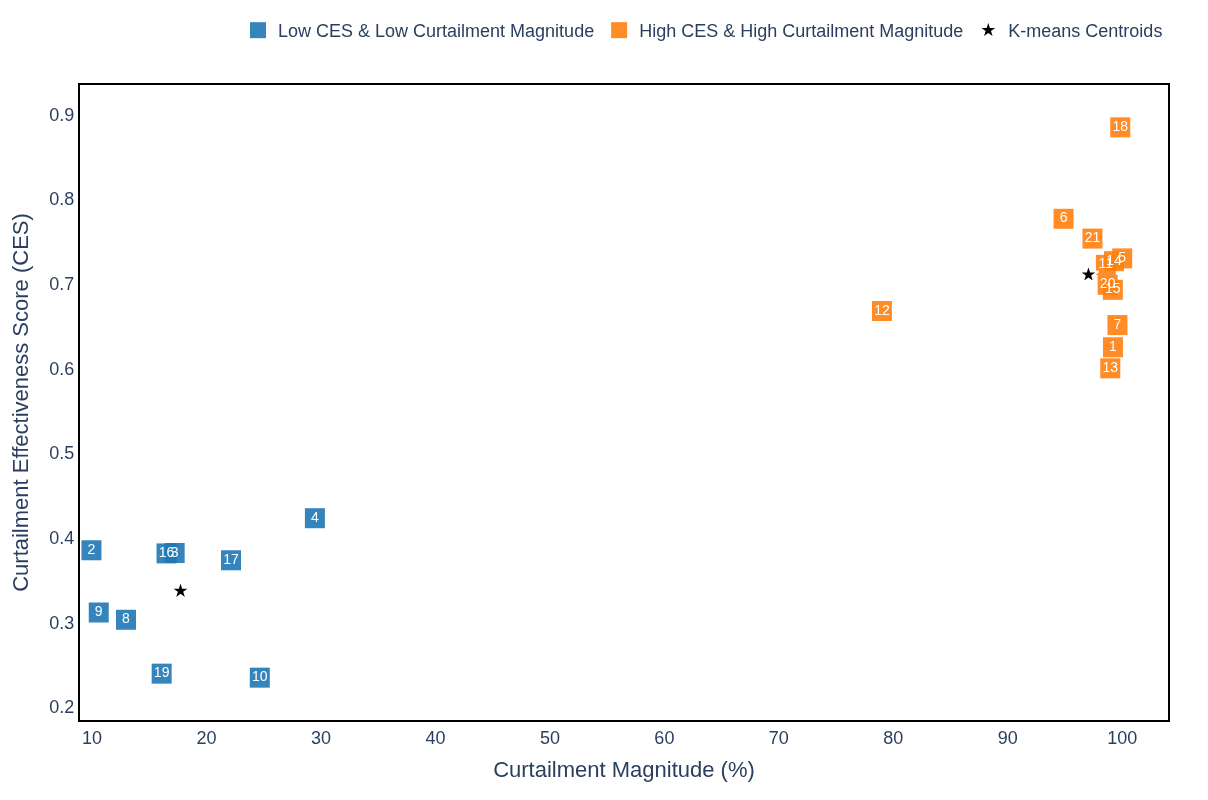

0.8252513164254683


In [129]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = uptime_df.copy()

# --- 2. Prepare Data for Clustering ---
X = df[['Curtailment Magnitude (%)', 'Targeting Efficiency Score (TES)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Compute Optimal k for K-means ---
k_range = range(2, 11)
results = []
silhouette_scores = {'K-means': []}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(X_scaled)
    kmeans_score = silhouette_score(X_scaled, kmeans_labels)
    silhouette_scores['K-means'].append(kmeans_score)
    
    results.append({'k': k, 'K-means Score': kmeans_score})

score_data = pd.DataFrame(results)
# NOTE: We enforce optimal_k=2 as per the request, overriding the calculation result if needed.
# optimal_k = score_data.loc[score_data['K-means Score'].idxmax(), 'k']
optimal_k = 2
best_score = score_data.loc[score_data['k'] == optimal_k, 'K-means Score'].iloc[0]
best_algorithm = 'K-means'


# --- 4. Rerun K-means Clustering with Enforced k=2 ---
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_kmeans.fit(X_scaled)
kmeans_labels = optimal_kmeans.labels_

# Adjust labels to be 1-indexed (1, 2)
df['Cluster'] = kmeans_labels + 1 

kmeans_centers_scaled = optimal_kmeans.cluster_centers_

# Unscale the cluster centers
kmeans_centers_unscaled = scaler.inverse_transform(kmeans_centers_scaled)
kmeans_centers_df = pd.DataFrame(
    kmeans_centers_unscaled,
    columns=['Curtailment Magnitude (%)', 'Targeting Efficiency Score (TES)']
)

# --- NEW LOGIC: DETERMINE DESCRIPTIVE CLUSTER NAMES ---
# Compare the centroids to assign the human-readable names.
# We'll use the Curtailment Magnitude as the primary differentiator.
low_cluster_id = kmeans_centers_df['Curtailment Magnitude (%)'].idxmin() + 1
high_cluster_id = kmeans_centers_df['Curtailment Magnitude (%)'].idxmax() + 1

# Define the cluster name mapping
cluster_name_map = {
    low_cluster_id: "Low CES & Low Curtailment Magnitude",
    high_cluster_id: "High CES & High Curtailment Magnitude",
}

# --- 5. Define Colors (Publication-Friendly Palette) ---
# The keys correspond to the 1-indexed Cluster labels (1, 2)
cluster_color_map = {
    1: 'rgba(31,119,180,0.9)',  # Blue (Default for Cluster 1)
    2: 'rgba(255,127,14,0.9)',  # Orange (Default for Cluster 2)
    3: 'rgba(44,160,44,0.9)',   
    4: 'rgba(148,103,189,0.9)', 
}

# Map cluster numbers to defined colors
df['Cluster Color'] = df['Cluster'].map(cluster_color_map)


# --- 6. Plot Optimal K-means Clustering Results with Target Layout ---

fig_kmeans = go.Figure()

# Add a trace for each cluster
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    color = cluster_color_map.get(cluster, 'gray')
    
    # Get the descriptive name using the cluster_name_map
    descriptive_name = cluster_name_map.get(cluster, f'Cluster {cluster}')
    
    fig_kmeans.add_trace(go.Scatter(
        x=cluster_data['Curtailment Magnitude (%)'],
        y=cluster_data['Targeting Efficiency Score (TES)'],
        mode='markers+text',
        name=descriptive_name, # Use the new descriptive name
        marker=dict(size=20, color=color, symbol='square'),
        text=cluster_data['Facility ID'],
        textposition='middle center',
        textfont=dict(size=14, color='white')
    ))

# Add cluster centers (centroids)
fig_kmeans.add_trace(go.Scatter(
    x=kmeans_centers_df['Curtailment Magnitude (%)'],
    y=kmeans_centers_df['Targeting Efficiency Score (TES)'],
    mode='markers',
    name='K-means Centroids',
    marker=dict(
        size=15,
        symbol='star',
        color='black',
        line=dict(width=2, color='white')
    )
))

# 7. APPLY TARGET LAYOUT STYLE
fig_kmeans.update_layout(
    font=dict(family='Arial', size=18),
    plot_bgcolor='white', width=1000, height=800,
    margin=dict(l=80, r=40, t=80, b=80),
    legend=dict(orientation='h', y=1.115, x=1, xanchor='right'),
    xaxis=dict(
        title='Curtailment Magnitude (%)', 
        range=[df['Curtailment Magnitude (%)'].min()-1, df['Curtailment Magnitude (%)'].max()+4],
        showgrid=False, zeroline=False, showline=True, linewidth=2, linecolor='black', mirror=True
    ),
    yaxis=dict(
        title='Curtailment Effectiveness Score (CES)', 
        range=[df['Targeting Efficiency Score (TES)'].min()-0.05, df['Targeting Efficiency Score (TES)'].max()+0.05],
        showgrid=False, zeroline=False, showline=True, linewidth=2, linecolor='black', mirror=True
    )
)

fig_kmeans.write_image('performance_clusters.png', width=1000, height=900, scale=4)
fig_kmeans.show()
print(best_score)

In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Setup: Data Preparation and K-Means Execution ---
# NOTE: df is assumed to be defined as uptime_df.copy() from the previous steps.

# --- 2. Prepare Data for Clustering ---
X = df[['Curtailment Magnitude (%)', 'Targeting Efficiency Score (TES)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Compute Optimal k (Enforcing k=2 as in previous context) ---
# For brevity, we skip the loop and enforce optimal_k = 2
optimal_k = 2

# --- 4. Rerun K-means Clustering with Enforced k=2 ---
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_kmeans.fit(X_scaled)
kmeans_labels = optimal_kmeans.labels_

# Adjust labels to be 1-indexed (1, 2)
df['Cluster'] = kmeans_labels + 1

# --- NEW LOGIC: Calculate Distance to Centroid and Summary Statistics ---

# 1. Calculate the Euclidean distance from every point to every centroid (on scaled data)
# This returns a matrix where rows are facilities and columns are centroids.
distances_to_all_centroids = optimal_kmeans.transform(X_scaled)

# 2. Select the distance to the *assigned* centroid for each facility.
# Since K-Means assigns a point to the closest centroid, the distance to the assigned 
# centroid is the minimum value across the row.
df['Distance to Centroid (Scaled)'] = distances_to_all_centroids.min(axis=1)

# 3. Group by cluster and compute summary statistics on the distance
distance_stats = df.groupby('Cluster')['Distance to Centroid (Scaled)'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).reset_index()

# 4. Optional: Add descriptive cluster names to the stats table for clarity
# Re-using the logic to map cluster ID to name
kmeans_centers_unscaled = scaler.inverse_transform(optimal_kmeans.cluster_centers_)
kmeans_centers_df = pd.DataFrame(
    kmeans_centers_unscaled,
    columns=['Curtailment Magnitude (%)', 'Targeting Efficiency Score (TES)']
)

low_cluster_id = kmeans_centers_df['Curtailment Magnitude (%)'].idxmin() + 1
high_cluster_id = kmeans_centers_df['Curtailment Magnitude (%)'].idxmax() + 1

cluster_name_map = {
    low_cluster_id: "Low CES & Low Curtailment Magnitude",
    high_cluster_id: "High CES & High Curtailment Magnitude",
}

distance_stats['Cluster Name'] = distance_stats['Cluster'].map(cluster_name_map)
distance_stats.set_index('Cluster', inplace=True)
distance_stats = distance_stats[['Cluster Name', 'count', 'mean', 'median', 'std', 'min', 'max']]

print(distance_stats)

                                  Cluster Name  count      mean    median  \
Cluster                                                                     
1          Low CES & Low Curtailment Magnitude      9  0.331606  0.227691   
2        High CES & High Curtailment Magnitude     12  0.310300  0.262211   

              std       min       max  
Cluster                                
1        0.147709  0.210049  0.547513  
2        0.250978  0.069809  0.884503  


# Misc

In [123]:
state_list = [
    {'Facility ID': 1,  'State': 'New York'},
    {'Facility ID': 2,  'State': 'Kentucky'},
    {'Facility ID': 3,  'State': 'Kentucky'},
    {'Facility ID': 4,  'State': 'Kentucky'},
    {'Facility ID': 5,  'State': 'Georgia'},
    {'Facility ID': 6,  'State': 'Texas'},
    {'Facility ID': 7,  'State': 'Texas'},
    {'Facility ID': 8,  'State': 'Georgia'},
    {'Facility ID': 9,  'State': 'Georgia'},
    {'Facility ID': 10, 'State': 'Georgia'},
    {'Facility ID': 11, 'State': 'Texas'},
    {'Facility ID': 12, 'State': 'Texas'},
    {'Facility ID': 13, 'State': 'North Dakota'},
    {'Facility ID': 14, 'State': 'Texas'},
    {'Facility ID': 15, 'State': 'Texas'},
    {'Facility ID': 16, 'State': 'North Carolina'},
    {'Facility ID': 17, 'State': 'North Carolina'},
    {'Facility ID': 18, 'State': 'Georgia'},
    {'Facility ID': 19, 'State': 'Quebec'},
    {'Facility ID': 20, 'State': 'Texas'},
    {'Facility ID': 21, 'State': 'Ohio'},
]

# turn the list of dicts into a DataFrame
state_df = pd.DataFrame(state_list)

# merge on 'Facility ID'
df = df.merge(
    state_df[['Facility ID', 'State']], 
    on='Facility ID', 
    how='left'
)

In [126]:
import pandas as pd

# Compute statistics for 'Targeting Efficiency Score (TES)' grouped by 'State'
state_tes_stats = df.groupby('State_x')['Targeting Efficiency Score (TES)'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).reset_index()

# Rename columns for clarity (optional, but good practice)
state_tes_stats.columns = ['State', 'Facility Count', 'TES Mean', 'TES Median', 'TES Std Dev', 'TES Min', 'TES Max']

print(state_tes_stats)

            State  Facility Count  TES Mean  TES Median  TES Std Dev  \
0         Georgia               5  0.492819    0.311708     0.293716   
1        Kentucky               3  0.396741    0.385192     0.022846   
2        New York               1  0.624897    0.624897          NaN   
3  North Carolina               2  0.377443    0.377443     0.005736   
4    North Dakota               1  0.600034    0.600034          NaN   
5            Ohio               1  0.753242    0.753242          NaN   
6          Quebec               1  0.239492    0.239492          NaN   
7           Texas               7  0.705096    0.698616     0.041576   

    TES Min   TES Max  
0  0.234765  0.884619  
1  0.381974  0.423055  
2  0.624897  0.624897  
3  0.373387  0.381499  
4  0.600034  0.600034  
5  0.753242  0.753242  
6  0.239492  0.239492  
7  0.651148  0.776625  


Plotting facilities and centered labels...
<urlopen error [Errno 110] Connection timed out>


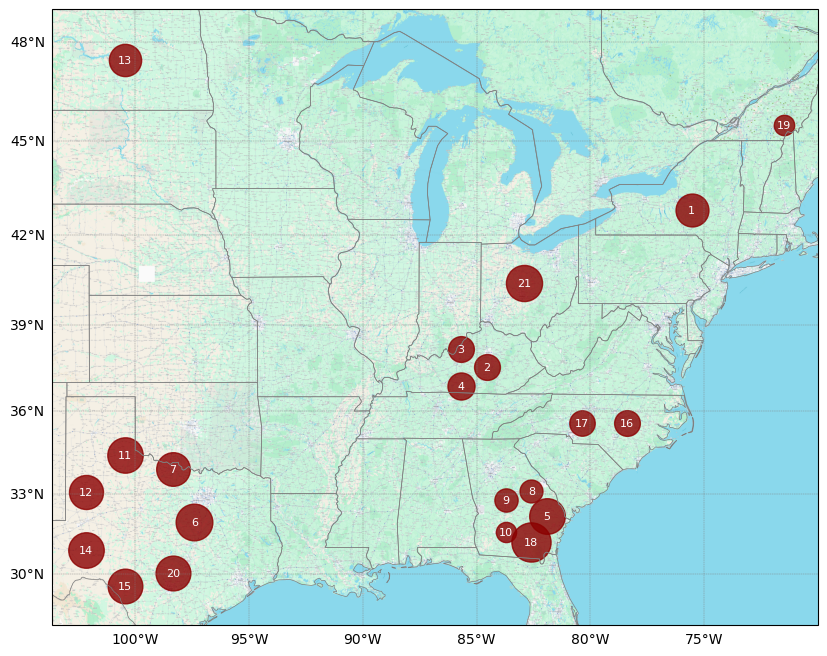

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import random
import numpy as np
from cartopy.io.img_tiles import GoogleTiles

# --- Data Preparation (copied from your original prompt) ---
locations = {
    'Texas': (31.9686, -99.9018),
    'New York': (42.8260, -75.5449),
    'Ohio': (40.4173, -82.9071),
    'Georgia': (32.1656, -82.9001),
    'Quebec': (45.5000, -71.5000),
    'North Dakota': (47.4501, -100.4659),
    'North Carolina': (35.5557, -79.3877),
    'Kentucky': (37.5347, -85.3021),
}

# Assume 'df' is a GeoDataFrame with 'State', 'Facility ID', and 'Targeting Efficiency Score (TES)' columns.
# Since the actual DataFrame creation is commented out, we'll create a minimal mock-up for demonstration.
states = list(locations.keys())

# define per-state jitter magnitudes (in degrees)
state_jitters = {
    'Texas': 2.5,
    'Georgia': 1.0,
    'Kentucky': 0.75,
    'North Carolina': 1.0
}

def circle_around_centroid(df, locations, state_jitters):
    # pre-allocate arrays
    lats = np.zeros(len(df), dtype=float)
    lons = np.zeros(len(df), dtype=float)

    for state, group in df.groupby('State'):
        base_lat, base_lon = locations[state]
        R = state_jitters.get(state, 0)
        idx = group.index.values

        if R > 0:
            # evenly spaced angles for each facility
            k = len(idx)
            angles = np.linspace(0, 2*np.pi, k, endpoint=False)
            # assign
            lats[idx] = base_lat + R * np.sin(angles)
            lons[idx] = base_lon + R * np.cos(angles)
        else:
            # no jitter: all points collapse to centroid
            lats[idx] = base_lat
            lons[idx] = base_lon

    return lats, lons

# apply it:
df['Latitude'], df['Longitude'] = circle_around_centroid(df, locations, state_jitters)
# --- End of Data Preparation ---

# --- Map Setup ---
tiler = GoogleTiles()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=tiler.crs)

lon_min, lon_max = df['Longitude'].min(), df['Longitude'].max()
lat_min, lat_max = df['Latitude'].min(), df['Latitude'].max()
pad = 1.5

ax.set_extent(
    [lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad],
    crs=ccrs.PlateCarree()
)

ax.add_image(tiler, 9)

states50 = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces', '50m',
    edgecolor='gray', facecolor='none', linewidth=0.5
)
ax.add_feature(states50)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linestyle='--', linewidth=0.3, color='gray'
)
gl.top_labels = False
gl.right_labels = False
# --- End of Map Setup ---


# --- Adjusted Plotting Logic ---

# 1. Choose Marker and Text Colors for Readability
marker_color = 'darkred' # Dark, noticeable marker
text_color = 'white'     # Light, contrasting text for visibility against the marker

# 2. Plot the facilities and center the text
print("Plotting facilities and centered labels...")
for _, row in df.iterrows():
    # Plot the circle marker
    ax.scatter(
        row['Longitude'], row['Latitude'],
        s=row['Targeting Efficiency Score (TES)'] * 900,
        color=marker_color, # Use the selected dark color
        alpha=0.8,
        transform=ccrs.PlateCarree()
    )

    # Add text label for Facility ID
    ax.text(
        row['Longitude'],
        row['Latitude'],
        row['Facility ID'],
        fontsize=8,
        color=text_color, # Use the selected light color
        # CENTER THE TEXT: set horizontal and vertical alignment to 'center'
        ha='center',
        va='center',
        transform=ccrs.PlateCarree()
    )

# --- Finalization ---
ax.scatter([], [], color=marker_color, alpha=0.8,
           label='Facilities', transform=ccrs.PlateCarree())
#ax.legend(loc='upper right', frameon=True)

#plt.title('Miner Facility Locations with Centered Labels', pad=12)
plt.savefig('facility_locations_adjusted.png', dpi=400, bbox_inches='tight')
plt.show()

## Remaining Meaningful Features

In [121]:
import pandas as pd

# Select only the numeric columns you want to include in the correlation table
numeric_cols = [
    'Facility ID',
    'Uptime (%)',
    'Avoided Emissions (tons CO2)',
#    'Induced Emissions (tons CO2)',
    'Maximum Energy (MWh)',
    # 'DR Active',
    # 'DR Relative (%)',
    'LME Variability (tons CO2/MWh)',
#    'Curtailment Regularity (hours)',
    'Curtailment Magnitude (%)',
    # 'Energy Savings',
    #'Emission Efficiency',
    'Threshold'
]

# Compute the correlation matrix
corr_matrix = uptime_df[numeric_cols].corr()

# Optionally, round to 2 decimal places for readability
corr_matrix = corr_matrix.round(2)

# And if you’d like to save it to CSV:
corr_matrix.to_csv('uptime_df_correlation_matrix.csv')

corr_matrix


Facility ID  Uptime (%)  \
Facility ID                            1.00       -0.16   
Uptime (%)                            -0.16        1.00   
Avoided Emissions (tons CO2)          -0.03       -0.48   
Maximum Energy (MWh)                  -0.13        0.09   
LME Variability (tons CO2/MWh)        -0.09        0.14   
Curtailment Magnitude (%)              0.18       -0.74   
Threshold                              0.02        0.64   

                                Avoided Emissions (tons CO2)  \
Facility ID                                            -0.03   
Uptime (%)                                             -0.48   
Avoided Emissions (tons CO2)                            1.00   
Maximum Energy (MWh)                                    0.50   
LME Variability (tons CO2/MWh)                          0.32   
Curtailment Magnitude (%)                               0.43   
Threshold                                              -0.10   

                                Maximum Energy (MWh)  \
Facility ID                                    -0.13   
Uptime (%)                                      0.09   
Avoided Emissions (tons CO2)                    0.50   
Maximum Energy (MWh)                            1.00   
LME Variability (tons CO2/MWh)                  0.07   
Curtailment Magnitude (%)                      -0.12   
Threshold                                       0.31   

                                LME Variability (tons CO2/MWh)  \
Facility ID                                              -0.09   
Uptime (%)                                                0.14   
Avoided Emissions (tons CO2)                              0.32   
Maximum Energy (MWh)                                      0.07   
LME Variability (tons CO2/MWh)                            1.00   
Curtailment Magnitude (%)                                 0.01   
Threshold                                                 0.31   

                                Curtailment Magnitude (%)  Threshold  
Facility ID                                          0.18       0.02  
Uptime (%)                                          -0.74       0.64  
Avoided Emissions (tons CO2)                         0.43      -0.10  
Maximum Energy (MWh)                                -0.12       0.31  
LME Variability (tons CO2/MWh)                       0.01       0.31  
Curtailment Magnitude (%)                            1.00      -0.44  
Threshold                                           -0.44       1.00

# Load Profiles For Case Study

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from scipy.stats import pearsonr

# --- A. Configuration ---
anonymized_dir = '/home/jyn_urso/gitea/bitcoin-mining-research/Load Profiles/Improved Results/Anonymized'

start_date = pd.to_datetime('2023-07-01')
end_date   = pd.to_datetime('2023-09-30 23:59:59')

# --- B. Load & filter each facility ---
dataframes = []
for file_name in os.listdir(anonymized_dir):
    if file_name.startswith('miner_') and file_name.endswith('.csv'):
        file_path   = os.path.join(anonymized_dir, file_name)
        facility_id = int(file_name.split('_')[1])
        
        df = pd.read_csv(file_path)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        mask = (df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)
        filtered_df = df.loc[mask].copy()
        filtered_df['Facility ID'] = facility_id
        
        filtered_df.reset_index(drop=True, inplace=True)
        dataframes.append(filtered_df)

# --- C. Concatenate all into one DataFrame ---
all_df = pd.concat(dataframes, ignore_index=True)

# --- D. Select which Facility IDs to plot ---
selected_ids = [6]  # <-- replace with the IDs you want
sel_df = all_df[all_df['Facility ID'].isin(selected_ids)]

# --- F. Build Plotly subplots with panel labels and color ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("<b>a</b>", "<b>b</b>") # Using bold for panel labels
)

# Add Energy trace
fig.add_trace(
    go.Scatter(
        x=sel_df['DateTime'],
        y=sel_df['energy'],
        mode='lines',
        line=dict(width=1.5, color='#1f77b4'),  # blue
        name='Energy'
    ),
    row=1, col=1
)
# Add LME trace
fig.add_trace(
    go.Scatter(
        x=sel_df['DateTime'],
        y=sel_df['LME'],
        mode='lines',
        line=dict(width=1.5, color='#d62728'),  # red
        name='LME'
    ),
    row=2, col=1
)

# --- G. UPDATE LAYOUT FOR PUBLICATION STYLE ---

# Apply axis titles
fig.update_yaxes(title_text="Energy (MWh)", row=1, col=1)
fig.update_yaxes(title_text="LME (tCO₂/MWh)", row=2, col=1) # Using tCO₂ for clarity
fig.update_xaxes(title_text="Date", row=2, col=1)

# Style axes for a clean, scientific look
fig.update_xaxes(
    showline=True,      # Add axis line
    linecolor='black',  # Set line color to black
    linewidth=1,        # Set line width
    ticks='outside',    # Move ticks outside the plot
    tickcolor='black',  # Set tick color to black
    mirror=True         # Create a box around the plot
)
fig.update_yaxes(
    showline=True,
    linecolor='black',
    linewidth=1,
    ticks='outside',
    tickcolor='black',
    mirror=True,
    showgrid=False      # Remove horizontal grid lines
)

# Final layout adjustments
fig.update_layout(
    height=500,
    width=700,
    plot_bgcolor='white', # Set background to white
    showlegend=False,
    font=dict(family='Arial', size=12, color='black'), # Set global font
    # Position subplot titles (a, b) to the top-left corner
    annotations=[dict(
        text="<b>a</b>", x=0, y=1.05, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    ), dict(
        text="<b>b</b>", x=0, y=0.45, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    )]
)

fig.write_image("facility_6_publication.png", scale=4)
fig.show()

# --- E. Compute Pearson correlation between energy and LME ---
r, p_value = pearsonr(sel_df['energy'], sel_df['LME'])
print(f"Pearson r = {r:.3f}, p = {p_value:.3f}")

Pearson r = nan, p = nan


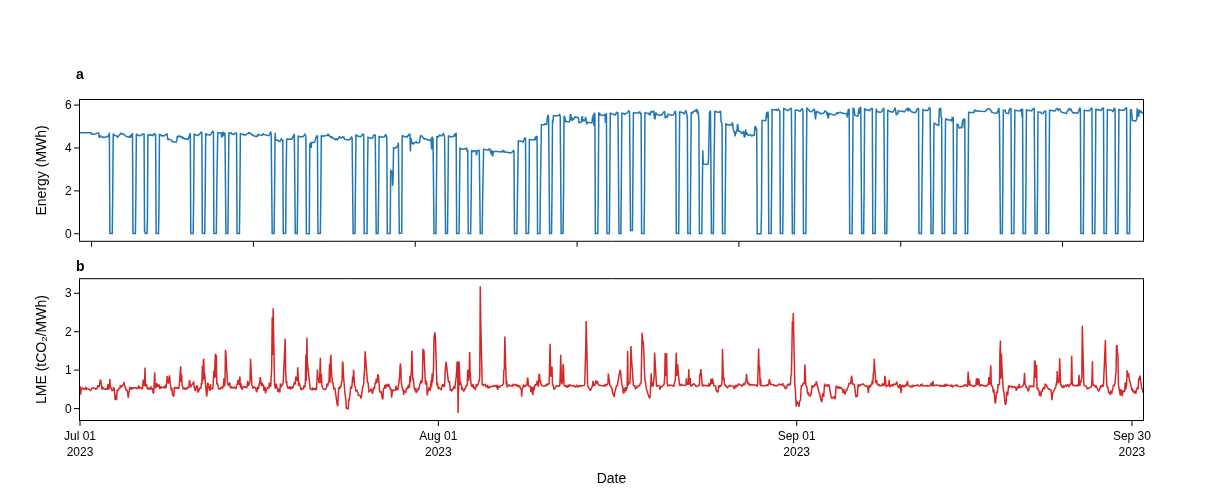

Pearson r = -0.451, p = 0.000


In [84]:
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import numpy as np 

# --- A. Configuration ---
anonymized_dir = '/home/jyn_urso/gitea/bitcoin-mining-research/Load Profiles/Improved Results/Anonymized'

start_date = pd.to_datetime('2023-07-01')
end_date = pd.to_datetime('2023-09-30 23:59:59')

# --- B. Load & filter each facility ---
dataframes = []
for file_name in os.listdir(anonymized_dir):
    if file_name.startswith('miner_') and file_name.endswith('.csv'):
        file_path = os.path.join(anonymized_dir, file_name)
        facility_id = int(file_name.split('_')[1])
        
        df = pd.read_csv(file_path)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        mask = (df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)
        filtered_df = df.loc[mask].copy()
        filtered_df['Facility ID'] = facility_id
        
        filtered_df.reset_index(drop=True, inplace=True)
        dataframes.append(filtered_df)

# --- C. Concatenate all into one DataFrame ---
all_df = pd.concat(dataframes, ignore_index=True)

# --- D. Select which Facility IDs to plot ---
selected_ids = [18] 
# Use .copy() to ensure we are working on a writable copy
sel_df = all_df[all_df['Facility ID'].isin(selected_ids)].copy() 

# STEP 1: Create a simple, formatted date string column for plotting data points
# This forces Plotly to treat the x-axis as strings, not numeric timestamps.
sel_df['Date_Label'] = sel_df['DateTime'].dt.strftime('%Y-%m-%d %H:%M') 

# --- E. Prepare Custom Date Ticks for Static Export ---
date_range = sel_df['DateTime']

# Create a list of the 1st day of each month for tick marks
tick_dates = pd.date_range(
    start=date_range.min().normalize(),
    end=date_range.max().normalize(),
    freq='MS' 
)
tick_dates = tick_dates.union([date_range.max().normalize()])

# THE FIX: Convert the DatetimeIndex to a Series before using .dt.strftime()
tick_dates_series = tick_dates.to_series() 
    
# STEP 2: Use the exact string format for tick values (must match 'Date_Label' format)
tick_vals = tick_dates_series.dt.strftime('%Y-%m-%d %H:%M').tolist() 

# STEP 3: Create the corresponding human-readable labels: "Month Day <br> Year"
tick_texts = tick_dates_series.dt.strftime("%b %d<br>%Y").tolist()

# --- F. Build Plotly subplots with panel labels and color ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("<b>a</b>", "<b>b</b>")
)

# Add Energy trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # USE STRING COLUMN HERE
        y=sel_df['energy'],
        mode='lines',
        line=dict(width=1.5, color='#1f77b4'), 
        name='Energy'
    ),
    row=1, col=1
)
# Add LME trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # USE STRING COLUMN HERE
        y=sel_df['LME'],
        mode='lines',
        line=dict(width=1.5, color='#d62728'), 
        name='LME'
    ),
    row=2, col=1
)

# --- G. UPDATE LAYOUT FOR PUBLICATION STYLE ---

# Apply axis titles
fig.update_yaxes(title_text="Energy (MWh)", row=1, col=1)
fig.update_yaxes(title_text="LME (tCO₂/MWh)", row=2, col=1) 

# Style the X-axis (Date) for the bottom plot (row=2, col=1)
fig.update_xaxes(
    title_text="Date", 
    row=2, col=1,
    
    # THE AGGRESSIVE FIX: Treat x-axis as discrete strings
    type='category', # Force x-axis to be treated as categorical strings
    tickmode='array',
    tickvals=tick_vals,  # The list of formatted string dates
    ticktext=tick_texts, # The list of clean display labels
    
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True           
)
fig.update_xaxes(
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True,
    # Crucially, target the first subplot's x-axis:
    row=1, col=1 
)

# Style Y-axes (Keep as is)
fig.update_yaxes(
    showline=True,
    linecolor='black',
    linewidth=1,
    ticks='outside',
    tickcolor='black',
    mirror=True,
    showgrid=False       
)

# Final layout adjustments (Keep as is)
fig.update_layout(
    height=500,
    width=700,
    plot_bgcolor='white', 
    showlegend=False,
    font=dict(family='Arial', size=12, color='black'), 
    annotations=[dict(
        text="<b>a</b>", x=0, y=1.05, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    ), dict(
        text="<b>b</b>", x=0, y=0.45, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    )]
)

fig.write_image("facility_18_publication.png", scale=4)
fig.show()

# --- H. Compute Pearson correlation between energy and LME ---
r, p_value = pearsonr(sel_df['energy'], sel_df['LME'])
print(f"Pearson r = {r:.3f}, p = {p_value:.3f}")

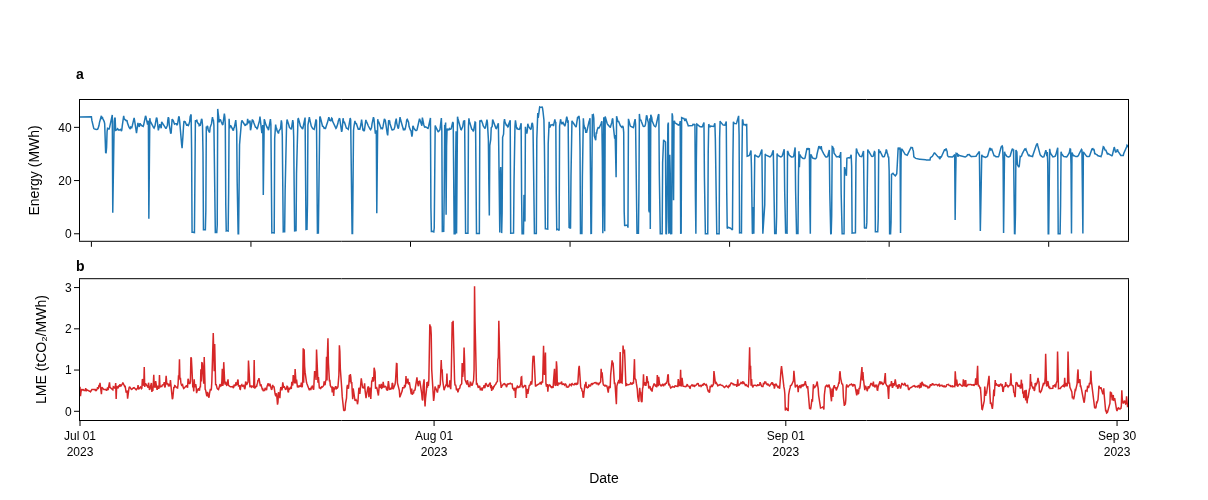

Pearson r = 0.056, p = 0.008


In [85]:
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import numpy as np 

# --- A. Configuration ---
anonymized_dir = '/home/jyn_urso/gitea/bitcoin-mining-research/Load Profiles/Improved Results/Anonymized'

start_date = pd.to_datetime('2023-07-01')
end_date = pd.to_datetime('2023-09-30 23:59:59')

# --- B. Load & filter each facility ---
dataframes = []
for file_name in os.listdir(anonymized_dir):
    if file_name.startswith('miner_') and file_name.endswith('.csv'):
        file_path = os.path.join(anonymized_dir, file_name)
        facility_id = int(file_name.split('_')[1])
        
        df = pd.read_csv(file_path)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        mask = (df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)
        filtered_df = df.loc[mask].copy()
        filtered_df['Facility ID'] = facility_id
        
        filtered_df.reset_index(drop=True, inplace=True)
        dataframes.append(filtered_df)

# --- C. Concatenate all into one DataFrame ---
all_df = pd.concat(dataframes, ignore_index=True)

# --- D. Select which Facility IDs to plot ---
selected_ids = [7] 
# Use .copy() to ensure we are working on a writable copy
sel_df = all_df[all_df['Facility ID'].isin(selected_ids)].copy() 

# STEP 1: Create a simple, formatted date string column for plotting data points
# This forces Plotly to treat the x-axis as strings, not numeric timestamps.
sel_df['Date_Label'] = sel_df['DateTime'].dt.strftime('%Y-%m-%d %H:%M') 

# --- E. Prepare Custom Date Ticks for Static Export ---
date_range = sel_df['DateTime']

# Create a list of the 1st day of each month for tick marks
tick_dates = pd.date_range(
    start=date_range.min().normalize(),
    end=date_range.max().normalize(),
    freq='MS' 
)
tick_dates = tick_dates.union([date_range.max().normalize()])

# THE FIX: Convert the DatetimeIndex to a Series before using .dt.strftime()
tick_dates_series = tick_dates.to_series() 
    
# STEP 2: Use the exact string format for tick values (must match 'Date_Label' format)
tick_vals = tick_dates_series.dt.strftime('%Y-%m-%d %H:%M').tolist() 

# STEP 3: Create the corresponding human-readable labels: "Month Day <br> Year"
tick_texts = tick_dates_series.dt.strftime("%b %d<br>%Y").tolist()

# --- F. Build Plotly subplots with panel labels and color ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("<b>a</b>", "<b>b</b>")
)

# Add Energy trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # USE STRING COLUMN HERE
        y=sel_df['energy'],
        mode='lines',
        line=dict(width=1.5, color='#1f77b4'), 
        name='Energy'
    ),
    row=1, col=1
)
# Add LME trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # USE STRING COLUMN HERE
        y=sel_df['LME'],
        mode='lines',
        line=dict(width=1.5, color='#d62728'), 
        name='LME'
    ),
    row=2, col=1
)

# --- G. UPDATE LAYOUT FOR PUBLICATION STYLE ---

# Apply axis titles
fig.update_yaxes(title_text="Energy (MWh)", row=1, col=1)
fig.update_yaxes(title_text="LME (tCO₂/MWh)", row=2, col=1) 

# Style the X-axis (Date) for the bottom plot (row=2, col=1)
fig.update_xaxes(
    title_text="Date", 
    row=2, col=1,
    
    # THE AGGRESSIVE FIX: Treat x-axis as discrete strings
    type='category', # Force x-axis to be treated as categorical strings
    tickmode='array',
    tickvals=tick_vals,  # The list of formatted string dates
    ticktext=tick_texts, # The list of clean display labels
    
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True           
)
fig.update_xaxes(
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True,
    # Crucially, target the first subplot's x-axis:
    row=1, col=1 
)

# Style Y-axes (Keep as is)
fig.update_yaxes(
    showline=True,
    linecolor='black',
    linewidth=1,
    ticks='outside',
    tickcolor='black',
    mirror=True,
    showgrid=False       
)

# Final layout adjustments (Keep as is)
fig.update_layout(
    height=500,
    width=700,
    plot_bgcolor='white', 
    showlegend=False,
    font=dict(family='Arial', size=12, color='black'), 
    annotations=[dict(
        text="<b>a</b>", x=0, y=1.05, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    ), dict(
        text="<b>b</b>", x=0, y=0.45, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    )]
)

fig.write_image("facility_7_publication.png", scale=4)
fig.show()

# --- H. Compute Pearson correlation between energy and LME ---
r, p_value = pearsonr(sel_df['energy'], sel_df['LME'])
print(f"Pearson r = {r:.3f}, p = {p_value:.3f}")

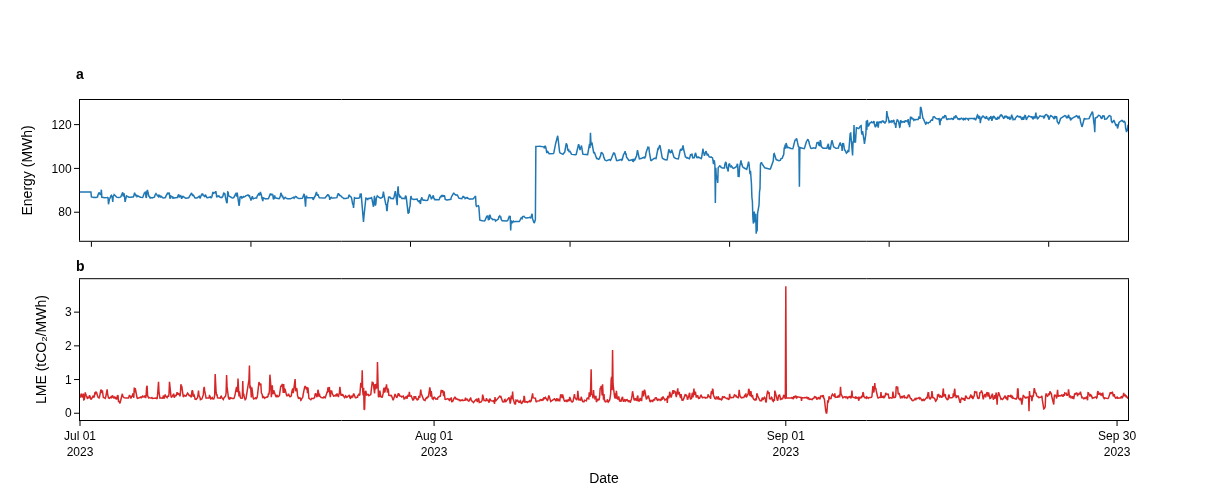

Pearson r = -0.035, p = 0.103


In [83]:
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import numpy as np 

# --- A. Configuration ---
anonymized_dir = '/home/jyn_urso/gitea/bitcoin-mining-research/Load Profiles/Improved Results/Anonymized'

start_date = pd.to_datetime('2023-07-01')
end_date = pd.to_datetime('2023-09-30 23:59:59')

# --- B. Load & filter each facility ---
dataframes = []
for file_name in os.listdir(anonymized_dir):
    if file_name.startswith('miner_') and file_name.endswith('.csv'):
        file_path = os.path.join(anonymized_dir, file_name)
        facility_id = int(file_name.split('_')[1])
        
        df = pd.read_csv(file_path)
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        
        mask = (df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)
        filtered_df = df.loc[mask].copy()
        filtered_df['Facility ID'] = facility_id
        
        filtered_df.reset_index(drop=True, inplace=True)
        dataframes.append(filtered_df)

# --- C. Concatenate all into one DataFrame ---
all_df = pd.concat(dataframes, ignore_index=True)

# --- D. Select which Facility IDs to plot ---
selected_ids = [10] 
# Use .copy() to ensure we are working on a writable copy
sel_df = all_df[all_df['Facility ID'].isin(selected_ids)].copy() 

# STEP 1: Create a simple, formatted date string column for plotting data points
# This forces Plotly to treat the x-axis as strings, not numeric timestamps.
sel_df['Date_Label'] = sel_df['DateTime'].dt.strftime('%Y-%m-%d %H:%M') 

# --- E. Prepare Custom Date Ticks for Static Export ---
date_range = sel_df['DateTime']

# Create a list of the 1st day of each month for tick marks
tick_dates = pd.date_range(
    start=date_range.min().normalize(),
    end=date_range.max().normalize(),
    freq='MS' 
)
tick_dates = tick_dates.union([date_range.max().normalize()])

# THE FIX: Convert the DatetimeIndex to a Series before using .dt.strftime()
tick_dates_series = tick_dates.to_series() 
    
# STEP 2: Use the exact string format for tick values (must match 'Date_Label' format)
tick_vals = tick_dates_series.dt.strftime('%Y-%m-%d %H:%M').tolist() 

# STEP 3: Create the corresponding human-readable labels: "Month Day <br> Year"
tick_texts = tick_dates_series.dt.strftime("%b %d<br>%Y").tolist()

# --- F. Build Plotly subplots with panel labels and color ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("<b>a</b>", "<b>b</b>")
)

# Add Energy trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # ⬅️ USE STRING COLUMN HERE
        y=sel_df['energy'],
        mode='lines',
        line=dict(width=1.5, color='#1f77b4'), 
        name='Energy'
    ),
    row=1, col=1
)
# Add LME trace - using the NEW 'Date_Label' column
fig.add_trace(
    go.Scatter(
        x=sel_df['Date_Label'], # ⬅️ USE STRING COLUMN HERE
        y=sel_df['LME'],
        mode='lines',
        line=dict(width=1.5, color='#d62728'), 
        name='LME'
    ),
    row=2, col=1
)

# --- G. UPDATE LAYOUT FOR PUBLICATION STYLE ---

# Apply axis titles
fig.update_yaxes(title_text="Energy (MWh)", row=1, col=1)
fig.update_yaxes(title_text="LME (tCO₂/MWh)", row=2, col=1) 

# Style the X-axis (Date) for the bottom plot (row=2, col=1)
fig.update_xaxes(
    title_text="Date", 
    row=2, col=1,
    
    # THE AGGRESSIVE FIX: Treat x-axis as discrete strings 
    type='category', # Force x-axis to be treated as categorical strings
    tickmode='array',
    tickvals=tick_vals,  # The list of formatted string dates
    ticktext=tick_texts, # The list of clean display labels
    
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True           
)
fig.update_xaxes(
    showline=True,        
    linecolor='black',    
    linewidth=1,          
    ticks='outside',      
    tickcolor='black',    
    mirror=True,
    # Crucially, target the first subplot's x-axis:
    row=1, col=1 
)

# Style Y-axes (Keep as is)
fig.update_yaxes(
    showline=True,
    linecolor='black',
    linewidth=1,
    ticks='outside',
    tickcolor='black',
    mirror=True,
    showgrid=False       
)

# Final layout adjustments (Keep as is)
fig.update_layout(
    height=500,
    width=700,
    plot_bgcolor='white', 
    showlegend=False,
    font=dict(family='Arial', size=12, color='black'), 
    annotations=[dict(
        text="<b>a</b>", x=0, y=1.05, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    ), dict(
        text="<b>b</b>", x=0, y=0.45, xref="paper", yref="paper",
        showarrow=False, font=dict(size=14)
    )]
)

fig.write_image("facility_10_publication.png", scale=4)
fig.show()

# --- H. Compute Pearson correlation between energy and LME ---
r, p_value = pearsonr(sel_df['energy'], sel_df['LME'])
print(f"Pearson r = {r:.3f}, p = {p_value:.3f}")